# Mini Project 3

Submitted By: Francesca Felizardo  
IOD Cohort Feb 2025  
July 21, 2025

Instructions:  

The purpose of this Mini Project is to reinforce skills covered in recent modules and give you flexibility to explore different modelling techniques.

You are encouraged to apply what you’ve learned so far, including methods such as regression, classification, clustering, natural language processing (NLP), neural networks, or others appropriate to your problem. Web scraping or API integration is optional.
Choose a dataset and identify a meaningful business problem. Translate that into a data science problem, and analyse the data using techniques from recent modules. These may include, but are not limited to:  

Data wrangling  
Exploratory Data Analysis (EDA)  
Feature importance and feature selection  
Text preprocessing (if NLP is used)  


Use appropriate modelling techniques based on the nature of your problem. If using supervised learning, evaluate model performance using metrics such as Accuracy, Precision, Recall, F1 Score, and Confusion Matrix. Also include visualisations such as:  

Partial Dependence Plots (for model interpretation)  
Actual vs. Expected plots (to evaluate prediction quality)  
Post-clustering analysis and Silhouette Score (if clustering is used) (optional)  

Compare the performance of your models (if applicable) and explain which model or approach best fits your business problem.
Presentations should be engaging, well-structured, and approximately 10 minutes long, designed for a non-technical audience or stakeholders
Clearly define the business problem and the goal of your analysis
Present evaluation metrics and visualisations to support your conclusions
Reflect on what worked well and what you would improve

### A. Data Definition and Scope

Content:
1. Invoice Dataset - Contains about 4 (2021 to 2024) years of invoice spend data with description, supplier, date and category information
2. Taxonomy - spend classification and categories as required by the procurement team

Source & Acknowledgements:
The observations are from real invoices captured from a Utility Energy Company in Australia

### B. Project Scope (to Capstone)

Stage 1: Invoice Classification (ML and LLMs) - Mini Project 3 Scope  
Stage 2: Time Series Forecasting of Spend  
Stage 3: Drift Detection and Explainability  
Stage 4: Deployment (Dashboard)

### C. Problem Statement

Stage 1: Invoice Classification (ML and LLMs) - Mini Project 3 Scope  

Re-categorise Invoice Lines tagged to "Equipment - Other Services" and "Unclassified" Commodity


### D. Data Preparation

In [2]:
## Import Libraries
import numpy as np
import pandas as pd

import string
import spacy

from collections import Counter

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Load Data

from google.colab import files
uploaded = files.upload()


Saving Spend_Filtered_Labelled.xlsx to Spend_Filtered_Labelled (4).xlsx
Saving Spend_For Classification.xlsx to Spend_For Classification (3).xlsx


In [5]:
df_labeled = pd.read_excel('Spend_Filtered_Labelled.xlsx', sheet_name="Spend")
df_unlabeled = pd.read_excel('Spend_For Classification.xlsx', sheet_name="Sheet1")

In [6]:
df_labeled.head()

,Supplier Name,Invoice ID,Category Name,Category ID,Paid Date,Invoice Description,Invoice Amount,Level 1 Category,Level 2 Category
0,LIBRAN IT PTY LTD,IR2433-75930,Labour Hire - Others,93141802,2024-05-23,increase the existing purchase order to extend...,24990.0,Business (Corporate) Services,Recruitment
1,LIBRAN IT PTY LTD,IR2780-81543,Labour Hire - Others,93141802,2024-08-22,increase the existing purchase order to extend...,29750.0,Business (Corporate) Services,Recruitment
2,LIBRAN IT PTY LTD,IR2548-77795,Labour Hire - Others,93141802,2024-06-20,increase the existing purchase order to extend...,23800.0,Business (Corporate) Services,Recruitment
3,LIBRAN IT PTY LTD,IR3097-86774,Labour Hire - Others,93141802,2024-11-21,Extension of Rohit Gupta as a MuleSoft Develop...,22610.0,Business (Corporate) Services,Recruitment
4,LIBRAN IT PTY LTD,IR2664-79428,Labour Hire - Others,93141802,2024-07-18,increase the existing purchase order to extend...,22610.0,Business (Corporate) Services,Recruitment


In [7]:
df_unlabeled.head()

,[INV]Supplier (Common Supplier),[INV] Invoice ID,[INV]ERP Commodity (ERP Commodity),[INV]ERP Commodity (ERP Commodity ID),[INV]Paid Date (Date),[INV] Description,sum(Amount Invoiced),MERGE - Commodity Map L1,MERGE - Commodity Map L2
0,GFF CONCEPTS PTY LTD ATF,IR100126-88995,Equipment - Other services,73152103,2024-12-12,Additional freight costs arising from the incr...,6600.0,Network Equipment,Equipment support Services
1,ON THE WIRE SERVICES PTY LTD,IRINV0146-93300,Equipment - Other services,73152103,2025-03-20,"Labour ( incl. TAHA + Vehicle ) : $ 8,414.00_x...",50245.0,Network Equipment,Equipment support Services
2,Fabrekate Pty Ltd,IR0473-93513,Equipment - Other services,73152103,2025-03-20,8 off TL-843308_01 twisted barrel tongues,13700.0,Network Equipment,Equipment support Services
3,Fabrekate Pty Ltd,IR0472-93506,Equipment - Other services,73152103,2025-03-20,8 off Post Insulator Support Bracket as per d...,8160.0,Network Equipment,Equipment support Services
4,WESTERMO DATA COMMUNICATIONS P/L,IRCD610003323-87882,Equipment - Other services,73152103,2024-12-05,MEDIA CONVERTER from Westermo required for new...,2249.0,Network Equipment,Equipment support Services


In [72]:
columns_needed = ["Invoice Description", "Level 2 Category"]
df_labeled = df_labeled[columns_needed].dropna()
df_unlabeled = df_unlabeled["[INV] Description"].dropna()

,Invoice Description,Level 2 Category
0,increase the existing purchase order to extend...,Recruitment
1,increase the existing purchase order to extend...,Recruitment
2,increase the existing purchase order to extend...,Recruitment
3,Extension of Rohit Gupta as a MuleSoft Develop...,Recruitment
4,increase the existing purchase order to extend...,Recruitment
...,...,...
109202,"160 KN,SHACKLE,GALV FORGED STEEL,TO REF. 160S ...",Asset Mgmnt - Spares
109203,"CHANNEL BRACKET,OHEW RISER, GALV STEELTO TRANS...",Asset Mgmnt - Spares
109204,"160 KN,SHACKLE,GALV FORGED STEEL,TO REF. 160S ...",Asset Mgmnt - Spares
109205,"160 KN,SHACKLE,GALV FORGED STEEL,TO REF. 160S ...",Asset Mgmnt - Spares


In [10]:
df_unlabeled

,[INV] Description
0,Additional freight costs arising from the incr...
1,"Labour ( incl. TAHA + Vehicle ) : $ 8,414.00_x..."
2,8 off TL-843308_01 twisted barrel tongues
3,8 off Post Insulator Support Bracket as per d...
4,MEDIA CONVERTER from Westermo required for new...
...,...
7595,"1611 VO25 - Uprating to ACCR ($951,349.85)"
7596,1611 VO24 - Painting of Transmission Line Stru...
7597,1611 VO20 - Storage of Project Materials ($615...
7598,"1611 VO23 - 450mm Access Tracks Culverts ($20,..."


In [11]:
!pip install nltk spacy
!python -m spacy download en_core_web_sm

import nltk
nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 86.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
import spacy
import pandas as pd
import re
import unicodedata
from nltk.corpus import stopwords

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# English stopwords
stop_words = set(stopwords.words("english"))

Cleaning To Be Completed:  
Normalize Unicode and remove accents  
Remove emails, URLs, digits, special characters  
Lowercase and strip extra whitespace  
Remove stopwords  
Perform lemmatization  
Retain named entities  
Output cleaned string of tokens  

In [13]:
def clean_column_spacy(text_series):
    cleaned_texts = []

    # Pre-cleaning: normalize, lowercase, strip emails/URLs, etc.
    preprocessed = []
    for text in text_series:
        if not isinstance(text, str):
            preprocessed.append("")
            continue

        text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
        text = text.lower()
        text = re.sub(r'\S+@\S+|http\S+|www\S+', '', text)  # emails/URLs
        text = re.sub(r'\b(po|invoice|ref|order|date|no)[\s:]*\S*', '', text)  # invoice metadata
        text = re.sub(r'\d+', '', text)  # digits
        text = re.sub(r'[^a-z\s]', '', text)  # punctuation
        text = re.sub(r'\s+', ' ', text).strip()  # extra whitespace

        preprocessed.append(text)

    # Efficient spaCy processing using nlp.pipe
    docs = nlp.pipe(preprocessed, batch_size=1000, disable=["parser", "tagger"])

    for doc in docs:
        named_entities = {ent.text.lower() for ent in doc.ents}
        tokens = []

        for token in doc:
            if token.text.lower() in named_entities:
                tokens.append(token.text.lower())
            elif not token.is_stop and token.lemma_.isalpha():
                tokens.append(token.lemma_.lower())

        cleaned_texts.append(" ".join(tokens))

    return cleaned_texts


In [14]:
df_labeled["clean_description"] = clean_column_spacy(df_labeled["Invoice Description"].astype(str))
df_unlabeled["clean_description"] = clean_column_spacy(df_unlabeled["[INV] Description"].astype(str))

In [15]:
df_labeled = df_labeled[df_labeled['Level 2 Category'] != 'Supply Chain']

In [16]:
df_labeled.head()

,Invoice Description,Level 2 Category,clean_description
0,increase the existing purchase order to extend...,Recruitment,increase existing purchase extend rohit gupta ...
1,increase the existing purchase order to extend...,Recruitment,increase existing purchase extend rohit gupta ...
2,increase the existing purchase order to extend...,Recruitment,increase existing purchase extend rohit gupta ...
3,Extension of Rohit Gupta as a MuleSoft Develop...,Recruitment,extension rohit gupta mulesoft developer digit...
4,increase the existing purchase order to extend...,Recruitment,increase existing purchase extend rohit gupta ...


In [17]:
df_unlabeled.head()

,[INV] Description,clean_description
0,Additional freight costs arising from the incr...,additional freight costs arising increase glob...
1,"Labour ( incl. TAHA + Vehicle ) : $ 8,414.00_x...",labour incl taha vehicle xd delivery xd loadin...
2,8 off TL-843308_01 twisted barrel tongues,tl twisted barrel tongues
3,8 off Post Insulator Support Bracket as per d...,insulator support bracket drawing tl
4,MEDIA CONVERTER from Westermo required for new...,media converter westermo required new ssb limo...


In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_labeled['Level 2 Category'] = le.fit_transform(df_labeled['Level 2 Category'])

# Save label mapping for inverse_transform later
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))


In [19]:
import time
import pandas as pd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Prepare data
X = df_labeled['clean_description']
y = df_labeled['Level 2 Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Best vectorizers
vectorizers = {
    'TF-IDF (Word)': TfidfVectorizer(max_features=10000),
    'TF-IDF (Char)': TfidfVectorizer(analyzer='char', ngram_range=(2, 4), max_features=10000)
}

# Best models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': LinearSVC()
}

# Total combinations for progress tracking
total_tasks = len(vectorizers) * len(models)
progress_bar = tqdm(total=total_tasks, desc="Evaluating Best Models")

# Store results
results = []

for vec_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        start_time = time.time()

        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', model)
        ])

        try:
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        except Exception as e:
            accuracy = precision = recall = f1 = 0
            print(f"\n❌ Error with {vec_name} + {model_name}: {e}")

        elapsed = time.time() - start_time

        results.append({
            'Vectorizer': vec_name,
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Train Time (s)': round(elapsed, 2)
        })

        # Detailed result after each combination
        print(f"\n✅ Completed: {vec_name} + {model_name}")
        print(f"    → Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
        print(f"    → Training Time: {elapsed:.2f} seconds")

        progress_bar.update(1)

progress_bar.close()

# Convert to DataFrame and sort
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

# Final result table
results_df


Evaluating Best Models:  25%|██▌       | 1/4 [00:55<02:47, 55.92s/it]


✅ Completed: TF-IDF (Word) + Logistic Regression
    → Accuracy: 0.8697 | Precision: 0.8759 | Recall: 0.8697 | F1: 0.8681
    → Training Time: 55.92 seconds


Evaluating Best Models:  50%|█████     | 2/4 [06:40<07:31, 225.97s/it]


✅ Completed: TF-IDF (Word) + SVM
    → Accuracy: 0.9009 | Precision: 0.9055 | Recall: 0.9009 | F1: 0.9006
    → Training Time: 345.01 seconds


Evaluating Best Models:  75%|███████▌  | 3/4 [11:20<04:10, 250.57s/it]


✅ Completed: TF-IDF (Char) + Logistic Regression
    → Accuracy: 0.8662 | Precision: 0.8721 | Recall: 0.8662 | F1: 0.8652
    → Training Time: 279.84 seconds


Evaluating Best Models: 100%|██████████| 4/4 [47:11<00:00, 707.81s/it] 


✅ Completed: TF-IDF (Char) + SVM
    → Accuracy: 0.9166 | Precision: 0.9205 | Recall: 0.9166 | F1: 0.9172
    → Training Time: 2150.45 seconds


,Vectorizer,Model,Accuracy,Precision,Recall,F1 Score,Train Time (s)
0,TF-IDF (Char),SVM,0.916579,0.920533,0.916579,0.917171,2150.45
1,TF-IDF (Word),SVM,0.900923,0.905544,0.900923,0.900620,345.01
2,TF-IDF (Word),Logistic Regression,0.869749,0.875928,0.869749,0.868114,55.92
3,TF-IDF (Char),Logistic Regression,0.866214,0.872108,0.866214,0.865193,279.84


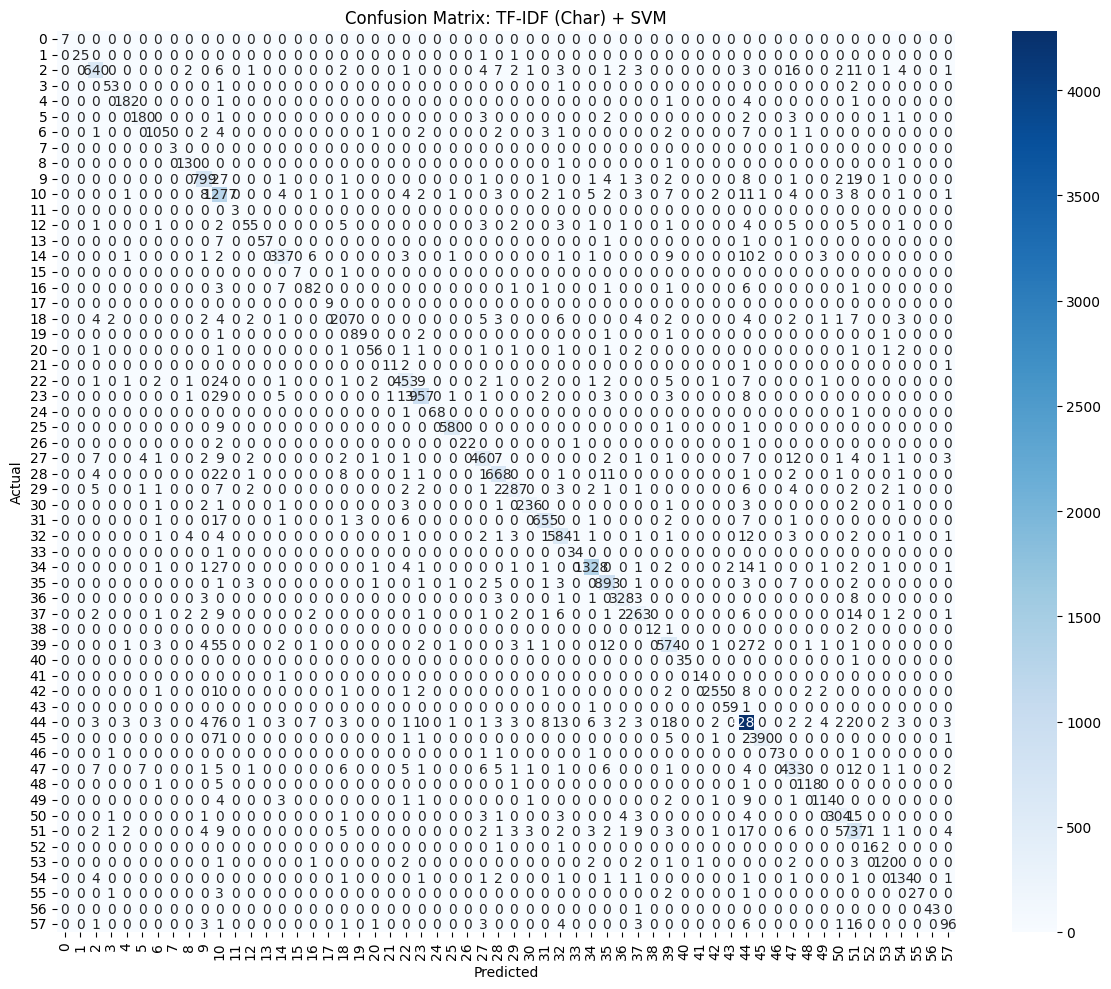

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get best combo from results
best_row = results_df.iloc[0]
best_vectorizer_name = best_row['Vectorizer']
best_model_name = best_row['Model']

# Rebuild pipeline with best combo
best_vectorizer = vectorizers[best_vectorizer_name]
best_model = models[best_model_name]

pipeline = Pipeline([
    ('vectorizer', best_vectorizer),
    ('classifier', best_model)
])

# Train on full train set
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=pipeline.classes_, yticklabels=pipeline.classes_, cmap="Blues")
plt.title(f'Confusion Matrix: {best_vectorizer_name} + {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [60]:
# Step 1: Select best vectorizer and model manually (TF-IDF Char + LinearSVC)
best_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4), max_features=10000)
best_model = LinearSVC()

# Step 2: Train on the full labeled dataset
pipeline = Pipeline([
    ('vectorizer', best_vectorizer),
    ('classifier', best_model)
])

pipeline.fit(df_labeled['clean_description'], df_labeled['Level 2 Category'])

# Step 3: Predict on the unlabeled data
df_unlabeled['Predicted Level 2 Category'] = pipeline.predict(df_unlabeled['clean_description'])

# Step 4: (Optional) View or save predictions
df_unlabeled[['clean_description', 'Predicted Level 2 Category']].head()



,clean_description,Predicted Level 2 Category
0,additional freight costs arising increase glob...,44
1,labour incl taha vehicle xd delivery xd loadin...,32
2,tl twisted barrel tongues,35
3,insulator support bracket drawing tl,44
4,media converter westermo required new ssb limo...,47


In [62]:
import joblib

# Save the trained model pipeline
joblib.dump(pipeline, 'tfidf_char_svm_pipeline.pkl')


['tfidf_char_svm_pipeline.pkl']

In [ ]:
#to load model later
# pipeline = joblib.load('tfidf_char_svm_pipeline.pkl')

In [65]:
# Convert integer prediction to category names
df_unlabeled['predicted_label_name'] = le.inverse_transform(df_unlabeled['Predicted Level 2 Category'])


In [66]:
df_unlabeled

,[INV] Description,clean_description,Predicted Level 2 Category,predicted_label_name
0,Additional freight costs arising from the incr...,additional freight costs arising increase glob...,44,Recruitment
1,"Labour ( incl. TAHA + Vehicle ) : $ 8,414.00_x...",labour incl taha vehicle xd delivery xd loadin...,32,Mobile Plant
2,8 off TL-843308_01 twisted barrel tongues,tl twisted barrel tongues,35,Office Products
3,8 off Post Insulator Support Bracket as per d...,insulator support bracket drawing tl,44,Recruitment
4,MEDIA CONVERTER from Westermo required for new...,media converter westermo required new ssb limo...,47,Secondary System Equipment
...,...,...,...,...
7595,"1611 VO25 - Uprating to ACCR ($951,349.85)",vo uprating accr,44,Recruitment
7596,1611 VO24 - Painting of Transmission Line Stru...,vo painting transmission line structures,36,Overhead Transmission Line Maintenance
7597,1611 VO20 - Storage of Project Materials ($615...,vo storage project materials,51,Substations
7598,"1611 VO23 - 450mm Access Tracks Culverts ($20,...",vo mm access tracks culverts,57,Underground Transmission Lines


In [67]:
from google.colab import files

# Save your DataFrame to CSV
df_unlabeled.to_csv("unlabeled_with_predictions.csv", index=False)

# Download it
files.download("unlabeled_with_predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>